# Objective: fine-tuning DETR

-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb
-   https://github.com/woctezuma/finetune-detr

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.5.1 True


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Load an image for a demo

In [6]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval()

Using cache found in /home/smajchrowska/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Drop

In [7]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [8]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

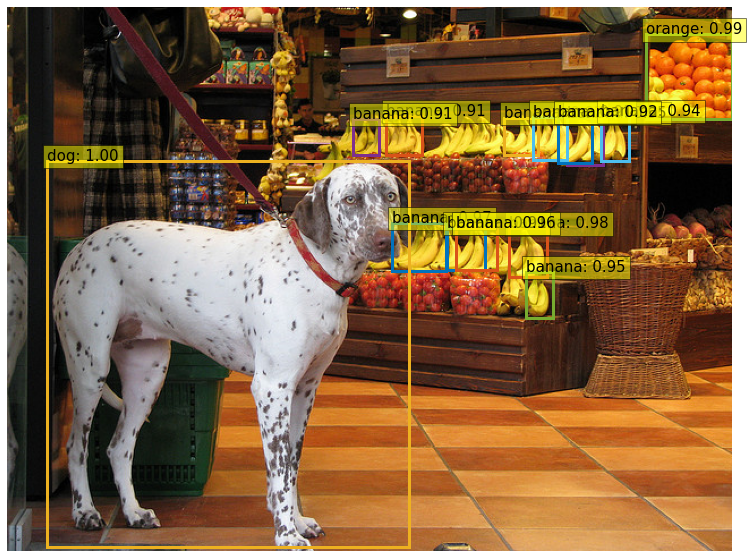

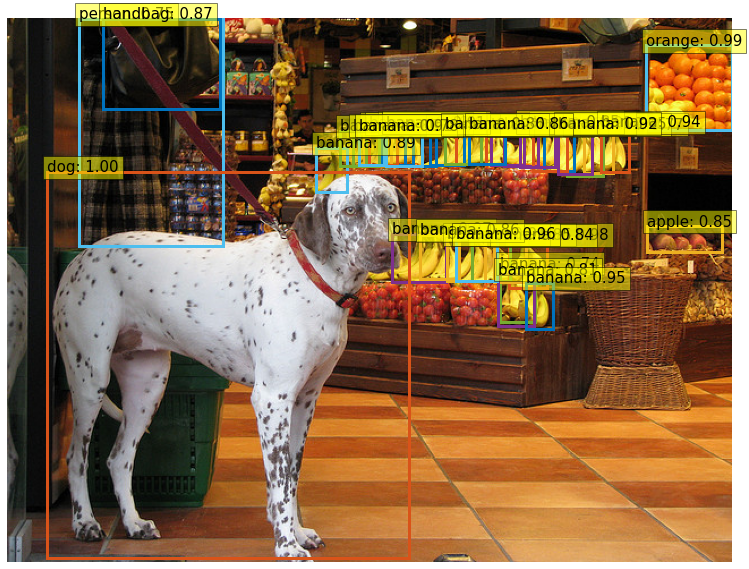

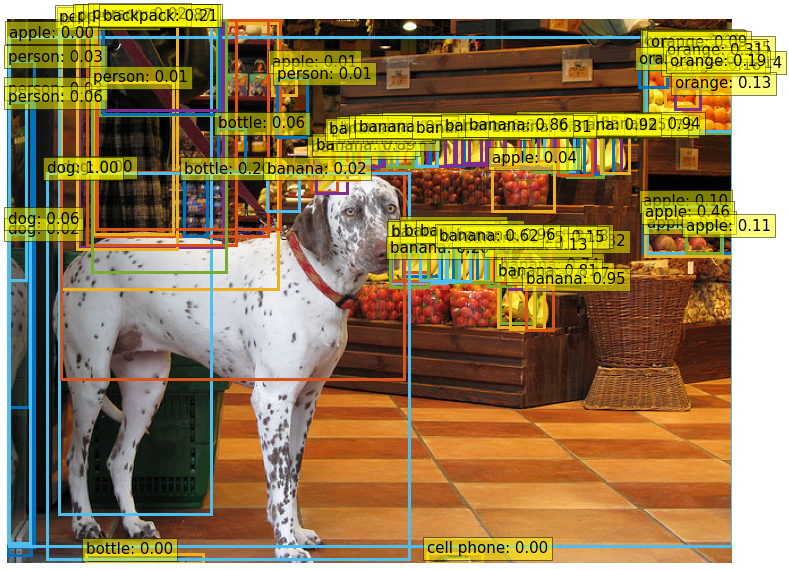

In [9]:
for threshold in [0.9, 0.7, 0.0]:
  
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

NB: if the threshold is equal to zero, then you will see all of the 100 query slots. The zero-threshold is only used for illustration. In usual cases, most query slots have a low confidence score, so that irrelevant query slots would be pruned with a higher threshold, such as 0.7 or 0.9.

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-635357693

NB²: For fine-tuning purposes, we cannot change the number of query slots.

> If you're fine-tuning, I don't recommend changing the number of queries on the fly, it is extremely unlikely to work out of the box. In this case you're probably better off retraining from scratch (you can change the --num_queries arg from our training script).

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-636407752

## Clone my custom code of DETR

Clone [my fork](https://github.com/woctezuma/detr/tree/finetune) tailored for a custom dataset:
-   called `custom`,
-   with `max_class_id = 2` ([explanation](https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223)).

**Caveat**: if you later use `first_class_index = 1` for your dataset, then it is fine. However, if you later use `first_class_index = 0`, then you will have to override the value of `max_class_id` (so that it is equal to 1) when calling `!python main.py`. My fork can do that.


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [10]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

## Prepare the dataset for fine-tuning

The `balloon` dataset will be used. It is featured here and uses VIA format:
-   https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon


You can choose whether to start indexing categories with 0 or with 1.

This is a matter of taste, and it should not impact the performance of the algorithm.

In [11]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0

Clone [woctezuma fork](https://github.com/woctezuma/VIA2COCO/tree/fixes) to convert annotations from VIA format to COCO format.

In [12]:
import os
from PIL import Image
import datetime
import json
import math


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y


def GetAreaOfPolyGon(points_x, points_y):
    points = []
    for index in range(len(points_x)):
        points.append(Point(points_x[index], points_y[index]))
    area = 0
    if len(points) < 3:

        raise Exception("error")

    p1 = points[0]
    for i in range(1, len(points) - 1):
        p2 = points[1]
        p3 = points[2]

        vecp1p2 = Point(p2.x - p1.x, p2.y - p1.y)
        vecp2p3 = Point(p3.x - p2.x, p3.y - p2.y)

        vecMult = vecp1p2.x * vecp2p3.y - vecp1p2.y * vecp2p3.x
        sign = 0
        if vecMult > 0:
            sign = 1
        elif vecMult < 0:
            sign = -1

        triArea = GetAreaOfTriangle(p1, p2, p3) * sign
        area += triArea
    return abs(area)


def GetAreaOfTriangle(p1, p2, p3):

    area = 0
    p1p2 = GetLineLength(p1, p2)
    p2p3 = GetLineLength(p2, p3)
    p3p1 = GetLineLength(p3, p1)
    s = (p1p2 + p2p3 + p3p1) / 2
    area = s * (s - p1p2) * (s - p2p3) * (s - p3p1)
    area = math.sqrt(area)
    return area


def GetLineLength(p1, p2):

    length = math.pow((p1.x - p2.x), 2) + math.pow((p1.y - p2.y), 2)
    length = math.sqrt(length)
    return length



def create_image_info(
    image_id,
    file_name,
    image_size,
    date_captured=datetime.datetime.utcnow().isoformat(" "),
    license_id=1,
    coco_url="",
    flickr_url="",
):
    image_info = {
        "id": image_id,
        "file_name": file_name,
        "width": image_size[0],
        "height": image_size[1],
        "date_captured": date_captured,
        "license": license_id,
        "coco_url": coco_url,
        "flickr_url": flickr_url,
    }

    return image_info


def create_annotation_info(
    annotation_id, image_id, category_id, is_crowd, area, bounding_box, segmentation
):
    annotation_info = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_id,
        "iscrowd": is_crowd,
        "area": area,  # float
        "bbox": bounding_box,  # [x,y,width,height]
        "segmentation": segmentation,  # [polygon]
    }

    return annotation_info


def get_segmenation(coord_x, coord_y):
    seg = []
    for x, y in zip(coord_x, coord_y):
        seg.append(x)
        seg.append(y)
    return [seg]


def convert(
    imgdir,
    annpath,
    categories=None,
    super_categories=None,
    output_file_name=None,
    first_class_index=1,  # typically, 0 or 1
):
    """
    :param imgdir: directory for your images
    :param annpath: path for your annotations
    :return: coco_output is a dictionary of coco style which you could dump it into a json file
    as for keywords 'info','licenses','categories',you should modify them manually
    """

    if categories is None:
        categories = ["rib", "clavicle"]

    default_category = categories[0]

    category_dict = dict()
    for (cat_id, cat_name) in enumerate(categories, start=first_class_index):
        category_dict[cat_name] = cat_id

    if super_categories is None:
        default_super_category = "bone"
        super_categories = [default_super_category for _ in categories]

    coco_output = {}
    coco_output["info"] = {
        "description": "Example Dataset",
        "url": "https://github.com/waspinator/pycococreator",
        "version": "0.1.0",
        "year": 2018,
        "contributor": "waspinator",
        "date_created": datetime.datetime.utcnow().isoformat(" "),
    }
    coco_output["licenses"] = [
        {
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License",
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
        }
    ]
    coco_output["categories"] = [
        {
            "id": category_dict[cat_name],
            "name": cat_name,
            "supercategory": super_cat_name,
        }
        for (cat_name, super_cat_name) in zip(categories, super_categories)
    ]
    coco_output["images"] = []
    coco_output["annotations"] = []

    ann = json.load(open(annpath))
    # annotations id start from zero
    ann_id = 0
    # in VIA annotations, keys are image name
    for img_id, key in enumerate(ann.keys()):

        filename = ann[key]["filename"]
        img = Image.open(imgdir + filename)
        # make image info and storage it in coco_output['images']
        image_info = create_image_info(
            img_id, os.path.basename(filename), image_size=img.size
        )
        # Caveat: image shapes are conventionally (height, width) whereas image sizes are conventionally (width, height)
        # References:
        # -   https://note.nkmk.me/en/python-opencv-pillow-image-size/
        # -   https://github.com/facebookresearch/detectron2/blob/master/detectron2/data/detection_utils.py#L189
        coco_output["images"].append(image_info)
        regions = ann[key]["regions"]
        # for one image ,there are many regions,they share the same img id
        for region in regions:
            region_attributes = regions[region]["region_attributes"]
            try:
                cat_name = region_attributes["label"]
            except KeyError:
                cat_name = default_category
            try:
                cat_id = category_dict[cat_name]
            except KeyError:
                print("Skipping unknown category {} in {}".format(cat_name, filename))
                continue
            iscrowd = 0
            shape_attributes = regions[region]["shape_attributes"]
            points_x = shape_attributes["all_points_x"]
            points_y = shape_attributes["all_points_y"]
            area = GetAreaOfPolyGon(points_x, points_y)
            min_x = min(points_x)
            max_x = max(points_x)
            min_y = min(points_y)
            max_y = max(points_y)
            box = [min_x, min_y, max_x - min_x, max_y - min_y]
            segmentation = get_segmenation(points_x, points_y)
            # make annotations info and storage it in coco_output['annotations']
            ann_info = create_annotation_info(
                ann_id, img_id, cat_id, iscrowd, area, box, segmentation
            )
            coco_output["annotations"].append(ann_info)
            ann_id = ann_id + 1

    if output_file_name is not None:
        print("Saving to {}".format(output_file_name))

        with open(output_file_name, "w") as f:
            json.dump(coco_output, f)

    return coco_output

In [17]:
data_path = '/home/smajchrowska/detr/'

for keyword in ['train', 'val']:

  input_dir = data_path + 'balloon/' + keyword + '/'
  input_json = input_dir + 'via_region_data.json'
  categories = ['balloon']
  super_categories = ['N/A']
  output_json = input_dir + 'custom_' + keyword + '.json'

  print('Converting {} from VIA format to COCO format'.format(input_json))

  coco_dict = convert(
      imgdir=input_dir,
      annpath=input_json,
      categories=categories,
      super_categories=super_categories,
      output_file_name=output_json,
      first_class_index=first_class_index,
  )

Converting /home/smajchrowska/detr/balloon/train/via_region_data.json from VIA format to COCO format
Saving to /home/smajchrowska/detr/balloon/train/custom_train.json
Converting /home/smajchrowska/detr/balloon/val/via_region_data.json from VIA format to COCO format
Saving to /home/smajchrowska/detr/balloon/val/custom_val.json


We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [15]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [16]:
dataDir='/home/smajchrowska/detr/balloon/'
dataType='train2017'
annFile='{}annotations/instances_{}.json'.format(dataDir, dataType)

In [17]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [18]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['balloon']
Super-categories: {'N/A'}


In [19]:
# load and display image
catIds = coco.getCatIds(catNms=['balloon']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°57
Image name: /home/smajchrowska/detr/balloon//train2017/145053828_e0e748717c_b.jpg


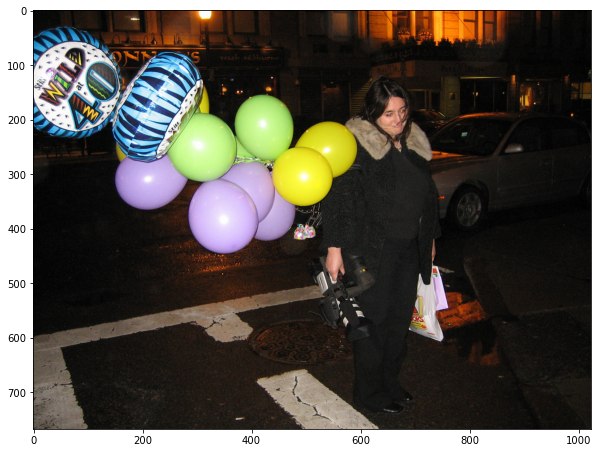

In [20]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [21]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

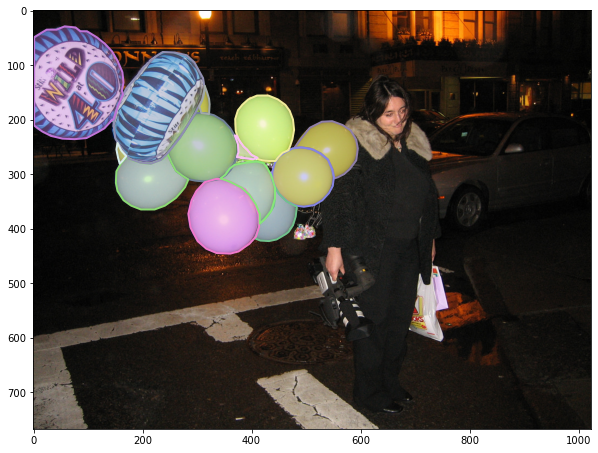

In [22]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

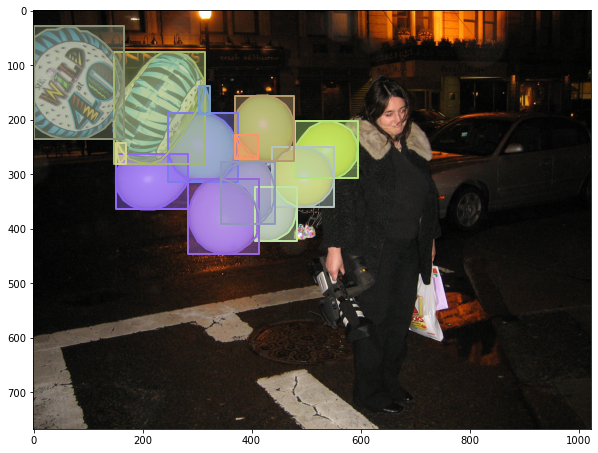

In [23]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/woctezuma/e9f8f9fe1737987351582e9441c46b5d).

There is a `--frozen_weights` argument. However, it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

### Boilerplate variables

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [40]:
!python main.py \
  --dataset_file "coco" \
  --coco_path $dataDir \
  --output_dir "outputs_ballons" \
  --resume "detr-r50_no-class-head.pth" \
  --epochs 10

Not using distributed mode
git:
  sha: a54b77800eb8e64e3ad0d8237789fcbf2f8350c5, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/home/smajchrowska/detr/balloon/', dataset_file='coco', dataset_mode='wimlds', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, optimizer='AdamW', output_dir='outputs_ballons', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
Namespace(aux_loss=True, backbone='re

Epoch: [0] Total time: 0:00:06 (0.2116 s / it)
Averaged stats: lr: 0.000100  class_error: 29.41  loss: 5.2840 (6.7494)  loss_ce: 0.3929 (0.4617)  loss_bbox: 0.2114 (0.2569)  loss_giou: 0.3136 (0.3716)  loss_ce_0: 0.4333 (0.5074)  loss_bbox_0: 0.1956 (0.2868)  loss_giou_0: 0.2778 (0.4157)  loss_ce_1: 0.4278 (0.4897)  loss_bbox_1: 0.1659 (0.2639)  loss_giou_1: 0.2829 (0.3907)  loss_ce_2: 0.4092 (0.4742)  loss_bbox_2: 0.1539 (0.2582)  loss_giou_2: 0.2828 (0.3829)  loss_ce_3: 0.3738 (0.4646)  loss_bbox_3: 0.2025 (0.2581)  loss_giou_3: 0.2929 (0.3774)  loss_ce_4: 0.3903 (0.4623)  loss_bbox_4: 0.2070 (0.2564)  loss_giou_4: 0.3134 (0.3709)  loss_ce_unscaled: 0.3929 (0.4617)  class_error_unscaled: 87.5000 (83.6514)  loss_bbox_unscaled: 0.0423 (0.0514)  loss_giou_unscaled: 0.1568 (0.1858)  cardinality_error_unscaled: 2.5000 (3.3333)  loss_ce_0_unscaled: 0.4333 (0.5074)  loss_bbox_0_unscaled: 0.0391 (0.0574)  loss_giou_0_unscaled: 0.1389 (0.2078)  cardinality_error_0_unscaled: 2.5000 (3.4000)  l

Epoch: [1]  [10/30]  eta: 0:00:04  lr: 0.000100  class_error: 20.00  loss: 4.6041 (4.6894)  loss_ce: 0.2808 (0.2978)  loss_bbox: 0.1725 (0.1728)  loss_giou: 0.2032 (0.2905)  loss_ce_0: 0.3357 (0.3708)  loss_bbox_0: 0.1622 (0.1828)  loss_giou_0: 0.2269 (0.3149)  loss_ce_1: 0.3126 (0.3382)  loss_bbox_1: 0.1722 (0.1720)  loss_giou_1: 0.1887 (0.2901)  loss_ce_2: 0.2824 (0.3109)  loss_bbox_2: 0.1682 (0.1661)  loss_giou_2: 0.1975 (0.2773)  loss_ce_3: 0.2623 (0.3007)  loss_bbox_3: 0.1638 (0.1661)  loss_giou_3: 0.1923 (0.2870)  loss_ce_4: 0.2637 (0.2988)  loss_bbox_4: 0.1781 (0.1650)  loss_giou_4: 0.1947 (0.2875)  loss_ce_unscaled: 0.2808 (0.2978)  class_error_unscaled: 28.5714 (31.9408)  loss_bbox_unscaled: 0.0345 (0.0346)  loss_giou_unscaled: 0.1016 (0.1453)  cardinality_error_unscaled: 2.5000 (3.0909)  loss_ce_0_unscaled: 0.3357 (0.3708)  loss_bbox_0_unscaled: 0.0324 (0.0366)  loss_giou_0_unscaled: 0.1134 (0.1574)  cardinality_error_0_unscaled: 1.5000 (2.2273)  loss_ce_1_unscaled: 0.3126 (0

Test:  [6/7]  eta: 0:00:00  class_error: 0.00  loss: 3.5950 (5.6995)  loss_ce: 0.2195 (0.2453)  loss_bbox: 0.1544 (0.1715)  loss_giou: 0.3501 (0.4828)  loss_ce_0: 0.3001 (0.3107)  loss_bbox_0: 0.1965 (0.2618)  loss_giou_0: 0.3848 (0.5957)  loss_ce_1: 0.2509 (0.2756)  loss_bbox_1: 0.1265 (0.2144)  loss_giou_1: 0.2978 (0.5053)  loss_ce_2: 0.2300 (0.2586)  loss_bbox_2: 0.1270 (0.1727)  loss_giou_2: 0.2934 (0.4669)  loss_ce_3: 0.2158 (0.2481)  loss_bbox_3: 0.1436 (0.1668)  loss_giou_3: 0.3034 (0.4532)  loss_ce_4: 0.2173 (0.2451)  loss_bbox_4: 0.1459 (0.1657)  loss_giou_4: 0.3074 (0.4592)  loss_ce_unscaled: 0.2195 (0.2453)  class_error_unscaled: 0.0000 (17.0996)  loss_bbox_unscaled: 0.0309 (0.0343)  loss_giou_unscaled: 0.1750 (0.2414)  cardinality_error_unscaled: 3.0000 (5.3571)  loss_ce_0_unscaled: 0.3001 (0.3107)  loss_bbox_0_unscaled: 0.0393 (0.0524)  loss_giou_0_unscaled: 0.1924 (0.2979)  cardinality_error_0_unscaled: 6.5000 (6.1429)  loss_ce_1_unscaled: 0.2509 (0.2756)  loss_bbox_1_uns

Epoch: [2]  [29/30]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 3.5909 (4.5304)  loss_ce: 0.1349 (0.1806)  loss_bbox: 0.1485 (0.1874)  loss_giou: 0.2678 (0.3314)  loss_ce_0: 0.2436 (0.2811)  loss_bbox_0: 0.1477 (0.2076)  loss_giou_0: 0.2770 (0.3796)  loss_ce_1: 0.1801 (0.2353)  loss_bbox_1: 0.1364 (0.1984)  loss_giou_1: 0.2717 (0.3541)  loss_ce_2: 0.1497 (0.2049)  loss_bbox_2: 0.1480 (0.2093)  loss_giou_2: 0.2819 (0.3512)  loss_ce_3: 0.1451 (0.1936)  loss_bbox_3: 0.1410 (0.1925)  loss_giou_3: 0.2656 (0.3323)  loss_ce_4: 0.1354 (0.1873)  loss_bbox_4: 0.1433 (0.1854)  loss_giou_4: 0.2513 (0.3182)  loss_ce_unscaled: 0.1349 (0.1806)  class_error_unscaled: 0.0000 (16.0552)  loss_bbox_unscaled: 0.0297 (0.0375)  loss_giou_unscaled: 0.1339 (0.1657)  cardinality_error_unscaled: 1.0000 (3.8000)  loss_ce_0_unscaled: 0.2436 (0.2811)  loss_bbox_0_unscaled: 0.0295 (0.0415)  loss_giou_0_unscaled: 0.1385 (0.1898)  cardinality_error_0_unscaled: 4.5000 (5.7500)  loss_ce_1_unscaled: 0.1801 (0.2

DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
Epoch

Test:  [0/7]  eta: 0:00:03  class_error: 12.50  loss: 4.0686 (4.0686)  loss_ce: 0.1182 (0.1182)  loss_bbox: 0.1282 (0.1282)  loss_giou: 0.3501 (0.3501)  loss_ce_0: 0.2563 (0.2563)  loss_bbox_0: 0.0980 (0.0980)  loss_giou_0: 0.3435 (0.3435)  loss_ce_1: 0.1666 (0.1666)  loss_bbox_1: 0.1877 (0.1877)  loss_giou_1: 0.5041 (0.5041)  loss_ce_2: 0.1343 (0.1343)  loss_bbox_2: 0.1549 (0.1549)  loss_giou_2: 0.4392 (0.4392)  loss_ce_3: 0.1111 (0.1111)  loss_bbox_3: 0.1269 (0.1269)  loss_giou_3: 0.3486 (0.3486)  loss_ce_4: 0.1201 (0.1201)  loss_bbox_4: 0.1283 (0.1283)  loss_giou_4: 0.3526 (0.3526)  loss_ce_unscaled: 0.1182 (0.1182)  class_error_unscaled: 12.5000 (12.5000)  loss_bbox_unscaled: 0.0256 (0.0256)  loss_giou_unscaled: 0.1751 (0.1751)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.2563 (0.2563)  loss_bbox_0_unscaled: 0.0196 (0.0196)  loss_giou_0_unscaled: 0.1718 (0.1718)  cardinality_error_0_unscaled: 4.5000 (4.5000)  loss_ce_1_unscaled: 0.1666 (0.1666)  loss_bbox_1_u

Epoch: [4]  [20/30]  eta: 0:00:02  lr: 0.000100  class_error: 9.09  loss: 3.5416 (4.1285)  loss_ce: 0.0544 (0.1005)  loss_bbox: 0.1893 (0.1921)  loss_giou: 0.3038 (0.3525)  loss_ce_0: 0.1484 (0.2074)  loss_bbox_0: 0.2096 (0.2159)  loss_giou_0: 0.3571 (0.3941)  loss_ce_1: 0.1128 (0.1614)  loss_bbox_1: 0.1661 (0.1909)  loss_giou_1: 0.3155 (0.3447)  loss_ce_2: 0.0761 (0.1166)  loss_bbox_2: 0.1802 (0.1979)  loss_giou_2: 0.2970 (0.3564)  loss_ce_3: 0.0660 (0.1005)  loss_bbox_3: 0.1906 (0.2004)  loss_giou_3: 0.3061 (0.3575)  loss_ce_4: 0.0561 (0.1014)  loss_bbox_4: 0.1791 (0.1907)  loss_giou_4: 0.2864 (0.3477)  loss_ce_unscaled: 0.0544 (0.1005)  class_error_unscaled: 0.0000 (3.8156)  loss_bbox_unscaled: 0.0379 (0.0384)  loss_giou_unscaled: 0.1519 (0.1763)  cardinality_error_unscaled: 1.0000 (2.9762)  loss_ce_0_unscaled: 0.1484 (0.2074)  loss_bbox_0_unscaled: 0.0419 (0.0432)  loss_giou_0_unscaled: 0.1786 (0.1970)  cardinality_error_0_unscaled: 2.5000 (3.6667)  loss_ce_1_unscaled: 0.1128 (0.16

Test: Total time: 0:00:01 (0.1880 s / it)
Averaged stats: class_error: 0.00  loss: 5.4382 (5.9827)  loss_ce: 0.1462 (0.2145)  loss_bbox: 0.1757 (0.1907)  loss_giou: 0.4822 (0.5648)  loss_ce_0: 0.2589 (0.2872)  loss_bbox_0: 0.1763 (0.2241)  loss_giou_0: 0.4623 (0.6076)  loss_ce_1: 0.2060 (0.2316)  loss_bbox_1: 0.2317 (0.2132)  loss_giou_1: 0.5071 (0.5845)  loss_ce_2: 0.2125 (0.2227)  loss_bbox_2: 0.1900 (0.1971)  loss_giou_2: 0.4971 (0.5659)  loss_ce_3: 0.2125 (0.2097)  loss_bbox_3: 0.1851 (0.1895)  loss_giou_3: 0.4953 (0.5315)  loss_ce_4: 0.1492 (0.1993)  loss_bbox_4: 0.1584 (0.1894)  loss_giou_4: 0.4951 (0.5592)  loss_ce_unscaled: 0.1462 (0.2145)  class_error_unscaled: 18.1818 (20.1144)  loss_bbox_unscaled: 0.0351 (0.0381)  loss_giou_unscaled: 0.2411 (0.2824)  cardinality_error_unscaled: 0.5000 (1.1429)  loss_ce_0_unscaled: 0.2589 (0.2872)  loss_bbox_0_unscaled: 0.0353 (0.0448)  loss_giou_0_unscaled: 0.2311 (0.3038)  cardinality_error_0_unscaled: 1.0000 (2.0000)  loss_ce_1_unscaled: 0

Epoch: [5] Total time: 0:00:06 (0.2056 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 3.9986 (4.1039)  loss_ce: 0.0790 (0.0983)  loss_bbox: 0.1705 (0.1863)  loss_giou: 0.2995 (0.3498)  loss_ce_0: 0.1569 (0.1952)  loss_bbox_0: 0.1913 (0.2144)  loss_giou_0: 0.3413 (0.3850)  loss_ce_1: 0.1222 (0.1461)  loss_bbox_1: 0.1959 (0.2119)  loss_giou_1: 0.2826 (0.3646)  loss_ce_2: 0.1198 (0.1210)  loss_bbox_2: 0.1747 (0.1946)  loss_giou_2: 0.2451 (0.3451)  loss_ce_3: 0.0853 (0.1042)  loss_bbox_3: 0.1963 (0.1985)  loss_giou_3: 0.2630 (0.3513)  loss_ce_4: 0.0825 (0.1013)  loss_bbox_4: 0.1692 (0.1895)  loss_giou_4: 0.3130 (0.3469)  loss_ce_unscaled: 0.0790 (0.0983)  class_error_unscaled: 0.0000 (6.4663)  loss_bbox_unscaled: 0.0341 (0.0373)  loss_giou_unscaled: 0.1497 (0.1749)  cardinality_error_unscaled: 0.5000 (2.3000)  loss_ce_0_unscaled: 0.1569 (0.1952)  loss_bbox_0_unscaled: 0.0383 (0.0429)  loss_giou_0_unscaled: 0.1707 (0.1925)  cardinality_error_0_unscaled: 3.0000 (4.8333)  loss

Epoch: [6]  [10/30]  eta: 0:00:04  lr: 0.000100  class_error: 0.00  loss: 3.7464 (3.8156)  loss_ce: 0.0959 (0.0846)  loss_bbox: 0.1455 (0.1660)  loss_giou: 0.3572 (0.3485)  loss_ce_0: 0.2172 (0.2011)  loss_bbox_0: 0.1912 (0.1897)  loss_giou_0: 0.3423 (0.3710)  loss_ce_1: 0.1463 (0.1437)  loss_bbox_1: 0.1566 (0.1748)  loss_giou_1: 0.3225 (0.3591)  loss_ce_2: 0.1264 (0.1076)  loss_bbox_2: 0.1449 (0.1605)  loss_giou_2: 0.3279 (0.3357)  loss_ce_3: 0.1093 (0.0943)  loss_bbox_3: 0.1549 (0.1565)  loss_giou_3: 0.3559 (0.3367)  loss_ce_4: 0.0980 (0.0858)  loss_bbox_4: 0.1501 (0.1597)  loss_giou_4: 0.3354 (0.3402)  loss_ce_unscaled: 0.0959 (0.0846)  class_error_unscaled: 0.0000 (2.8638)  loss_bbox_unscaled: 0.0291 (0.0332)  loss_giou_unscaled: 0.1786 (0.1743)  cardinality_error_unscaled: 2.5000 (2.9545)  loss_ce_0_unscaled: 0.2172 (0.2011)  loss_bbox_0_unscaled: 0.0382 (0.0379)  loss_giou_0_unscaled: 0.1712 (0.1855)  cardinality_error_0_unscaled: 5.5000 (6.1364)  loss_ce_1_unscaled: 0.1463 (0.14

Test:  [6/7]  eta: 0:00:00  class_error: 0.00  loss: 3.0817 (5.1977)  loss_ce: 0.0614 (0.1812)  loss_bbox: 0.1374 (0.1784)  loss_giou: 0.3152 (0.4854)  loss_ce_0: 0.1680 (0.2342)  loss_bbox_0: 0.1831 (0.2060)  loss_giou_0: 0.4019 (0.5740)  loss_ce_1: 0.1172 (0.2171)  loss_bbox_1: 0.1296 (0.1700)  loss_giou_1: 0.3259 (0.4717)  loss_ce_2: 0.0868 (0.1853)  loss_bbox_2: 0.1135 (0.1703)  loss_giou_2: 0.3393 (0.4555)  loss_ce_3: 0.0840 (0.1816)  loss_bbox_3: 0.1192 (0.1752)  loss_giou_3: 0.2880 (0.4694)  loss_ce_4: 0.0708 (0.1857)  loss_bbox_4: 0.1286 (0.1777)  loss_giou_4: 0.3231 (0.4791)  loss_ce_unscaled: 0.0614 (0.1812)  class_error_unscaled: 14.2857 (16.5430)  loss_bbox_unscaled: 0.0275 (0.0357)  loss_giou_unscaled: 0.1576 (0.2427)  cardinality_error_unscaled: 0.5000 (1.1429)  loss_ce_0_unscaled: 0.1680 (0.2342)  loss_bbox_0_unscaled: 0.0366 (0.0412)  loss_giou_0_unscaled: 0.2009 (0.2870)  cardinality_error_0_unscaled: 5.5000 (4.8571)  loss_ce_1_unscaled: 0.1172 (0.2171)  loss_bbox_1_un

Epoch: [7]  [29/30]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 3.3397 (3.9284)  loss_ce: 0.0302 (0.0787)  loss_bbox: 0.1560 (0.1804)  loss_giou: 0.3264 (0.3627)  loss_ce_0: 0.1114 (0.1749)  loss_bbox_0: 0.1935 (0.2101)  loss_giou_0: 0.3463 (0.3957)  loss_ce_1: 0.0876 (0.1317)  loss_bbox_1: 0.1791 (0.1921)  loss_giou_1: 0.3123 (0.3613)  loss_ce_2: 0.0504 (0.1029)  loss_bbox_2: 0.1565 (0.1796)  loss_giou_2: 0.2625 (0.3520)  loss_ce_3: 0.0320 (0.0887)  loss_bbox_3: 0.1510 (0.1766)  loss_giou_3: 0.2922 (0.3493)  loss_ce_4: 0.0343 (0.0892)  loss_bbox_4: 0.1536 (0.1693)  loss_giou_4: 0.2959 (0.3332)  loss_ce_unscaled: 0.0302 (0.0787)  class_error_unscaled: 0.0000 (3.4278)  loss_bbox_unscaled: 0.0312 (0.0361)  loss_giou_unscaled: 0.1632 (0.1814)  cardinality_error_unscaled: 0.5000 (1.5167)  loss_ce_0_unscaled: 0.1114 (0.1749)  loss_bbox_0_unscaled: 0.0387 (0.0420)  loss_giou_0_unscaled: 0.1731 (0.1978)  cardinality_error_0_unscaled: 2.5000 (4.6833)  loss_ce_1_unscaled: 0.0876 (0.13

Epoch: [8]  [ 0/30]  eta: 0:00:12  lr: 0.000100  class_error: 0.00  loss: 2.3223 (2.3223)  loss_ce: 0.0310 (0.0310)  loss_bbox: 0.1731 (0.1731)  loss_giou: 0.1617 (0.1617)  loss_ce_0: 0.1164 (0.1164)  loss_bbox_0: 0.2115 (0.2115)  loss_giou_0: 0.1714 (0.1714)  loss_ce_1: 0.0782 (0.0782)  loss_bbox_1: 0.1492 (0.1492)  loss_giou_1: 0.1559 (0.1559)  loss_ce_2: 0.0489 (0.0489)  loss_bbox_2: 0.1634 (0.1634)  loss_giou_2: 0.1551 (0.1551)  loss_ce_3: 0.0411 (0.0411)  loss_bbox_3: 0.1519 (0.1519)  loss_giou_3: 0.1488 (0.1488)  loss_ce_4: 0.0355 (0.0355)  loss_bbox_4: 0.1688 (0.1688)  loss_giou_4: 0.1605 (0.1605)  loss_ce_unscaled: 0.0310 (0.0310)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0346 (0.0346)  loss_giou_unscaled: 0.0808 (0.0808)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.1164 (0.1164)  loss_bbox_0_unscaled: 0.0423 (0.0423)  loss_giou_0_unscaled: 0.0857 (0.0857)  cardinality_error_0_unscaled: 2.0000 (2.0000)  loss_ce_1_unscaled: 0.0782 (0.07

Test:  [0/7]  eta: 0:00:03  class_error: 0.00  loss: 3.8036 (3.8036)  loss_ce: 0.0903 (0.0903)  loss_bbox: 0.1517 (0.1517)  loss_giou: 0.3946 (0.3946)  loss_ce_0: 0.2087 (0.2087)  loss_bbox_0: 0.1231 (0.1231)  loss_giou_0: 0.3354 (0.3354)  loss_ce_1: 0.1554 (0.1554)  loss_bbox_1: 0.1140 (0.1140)  loss_giou_1: 0.4113 (0.4113)  loss_ce_2: 0.1168 (0.1168)  loss_bbox_2: 0.1198 (0.1198)  loss_giou_2: 0.3706 (0.3706)  loss_ce_3: 0.0946 (0.0946)  loss_bbox_3: 0.1321 (0.1321)  loss_giou_3: 0.3842 (0.3842)  loss_ce_4: 0.0980 (0.0980)  loss_bbox_4: 0.1419 (0.1419)  loss_giou_4: 0.3612 (0.3612)  loss_ce_unscaled: 0.0903 (0.0903)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0303 (0.0303)  loss_giou_unscaled: 0.1973 (0.1973)  cardinality_error_unscaled: 3.5000 (3.5000)  loss_ce_0_unscaled: 0.2087 (0.2087)  loss_bbox_0_unscaled: 0.0246 (0.0246)  loss_giou_0_unscaled: 0.1677 (0.1677)  cardinality_error_0_unscaled: 8.0000 (8.0000)  loss_ce_1_unscaled: 0.1554 (0.1554)  loss_bbox_1_unsc

Epoch: [9]  [20/30]  eta: 0:00:02  lr: 0.000100  class_error: 0.00  loss: 3.1697 (3.9285)  loss_ce: 0.0355 (0.0783)  loss_bbox: 0.1531 (0.1990)  loss_giou: 0.2969 (0.3460)  loss_ce_0: 0.1363 (0.1728)  loss_bbox_0: 0.1983 (0.2108)  loss_giou_0: 0.3613 (0.3748)  loss_ce_1: 0.0863 (0.1276)  loss_bbox_1: 0.1658 (0.1989)  loss_giou_1: 0.3049 (0.3503)  loss_ce_2: 0.0608 (0.1082)  loss_bbox_2: 0.1533 (0.1869)  loss_giou_2: 0.2871 (0.3343)  loss_ce_3: 0.0460 (0.0908)  loss_bbox_3: 0.1444 (0.1904)  loss_giou_3: 0.2971 (0.3380)  loss_ce_4: 0.0380 (0.0792)  loss_bbox_4: 0.1487 (0.2006)  loss_giou_4: 0.2931 (0.3416)  loss_ce_unscaled: 0.0355 (0.0783)  class_error_unscaled: 0.0000 (3.3884)  loss_bbox_unscaled: 0.0306 (0.0398)  loss_giou_unscaled: 0.1485 (0.1730)  cardinality_error_unscaled: 0.5000 (1.6667)  loss_ce_0_unscaled: 0.1363 (0.1728)  loss_bbox_0_unscaled: 0.0397 (0.0422)  loss_giou_0_unscaled: 0.1806 (0.1874)  cardinality_error_0_unscaled: 4.0000 (4.5714)  loss_ce_1_unscaled: 0.0863 (0.12

Averaged stats: class_error: 0.00  loss: 4.4666 (5.7864)  loss_ce: 0.0381 (0.1870)  loss_bbox: 0.1778 (0.2130)  loss_giou: 0.4717 (0.5443)  loss_ce_0: 0.2085 (0.2531)  loss_bbox_0: 0.1870 (0.2271)  loss_giou_0: 0.5478 (0.6224)  loss_ce_1: 0.1118 (0.2074)  loss_bbox_1: 0.2028 (0.2209)  loss_giou_1: 0.5195 (0.5640)  loss_ce_2: 0.0869 (0.1961)  loss_bbox_2: 0.1486 (0.1950)  loss_giou_2: 0.4114 (0.5297)  loss_ce_3: 0.0651 (0.1911)  loss_bbox_3: 0.1636 (0.2004)  loss_giou_3: 0.4103 (0.5120)  loss_ce_4: 0.0430 (0.1767)  loss_bbox_4: 0.1772 (0.2078)  loss_giou_4: 0.4763 (0.5383)  loss_ce_unscaled: 0.0381 (0.1870)  class_error_unscaled: 0.0000 (12.2511)  loss_bbox_unscaled: 0.0356 (0.0426)  loss_giou_unscaled: 0.2359 (0.2722)  cardinality_error_unscaled: 0.5000 (1.5000)  loss_ce_0_unscaled: 0.2085 (0.2531)  loss_bbox_0_unscaled: 0.0374 (0.0454)  loss_giou_0_unscaled: 0.2739 (0.3112)  cardinality_error_0_unscaled: 4.0000 (4.7857)  loss_ce_1_unscaled: 0.1118 (0.2074)  loss_bbox_1_unscaled: 0.040

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [39]:
from util.plot_utils import plot_logs
from pathlib import Path

num_classes = 1

finetuned_classes = ['balloon']
log_directory = [Path('/home/smajchrowska/detr/outputs_ballons/')]

As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

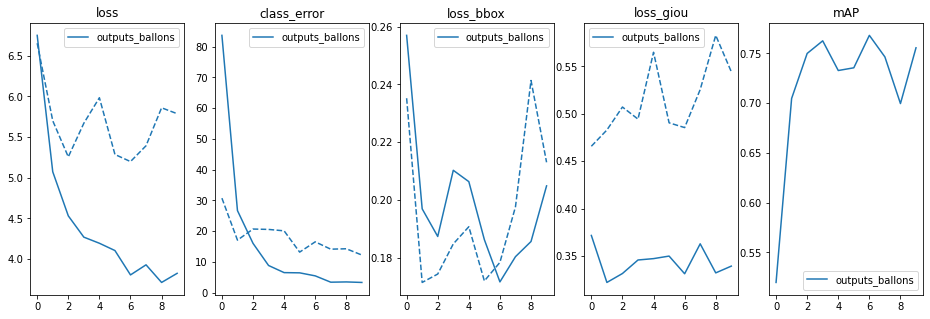

In [40]:
fields_of_interest = (
    'loss','class_error','loss_bbox','loss_giou','mAP'
    )

plot_logs(log_directory,
          fields_of_interest)

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [41]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('/home/smajchrowska/detr/outputs_ballons/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /home/smajchrowska/.cache/torch/hub/facebookresearch_detr_master


### Boilerplate functions to display fine-tuned results

In [42]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [43]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


### With a training image

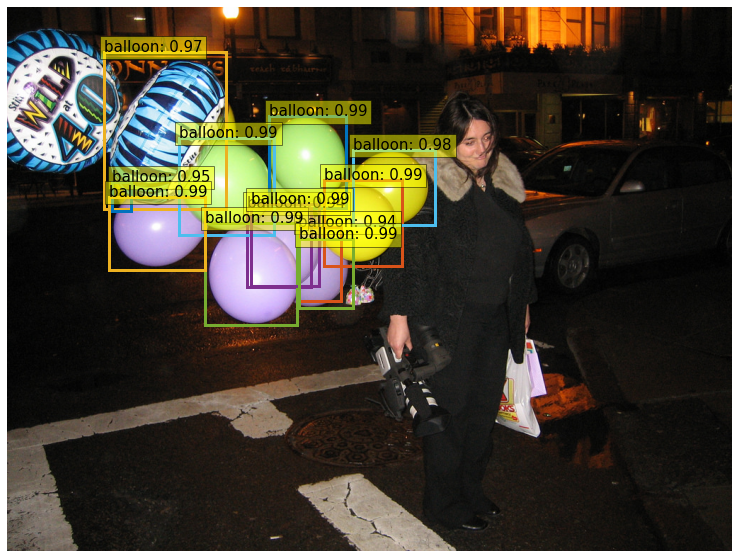

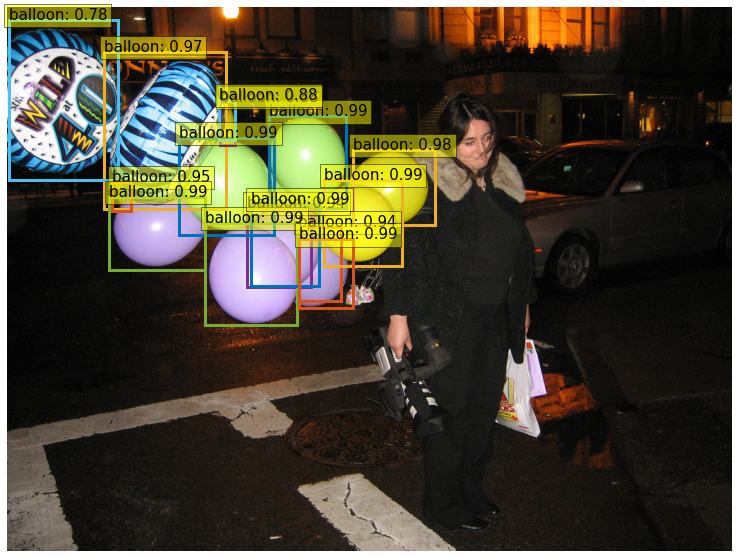

In [44]:
from PIL import Image

img_name = '/home/smajchrowska/detr/balloon/train2017/145053828_e0e748717c_b.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

### With a validation image

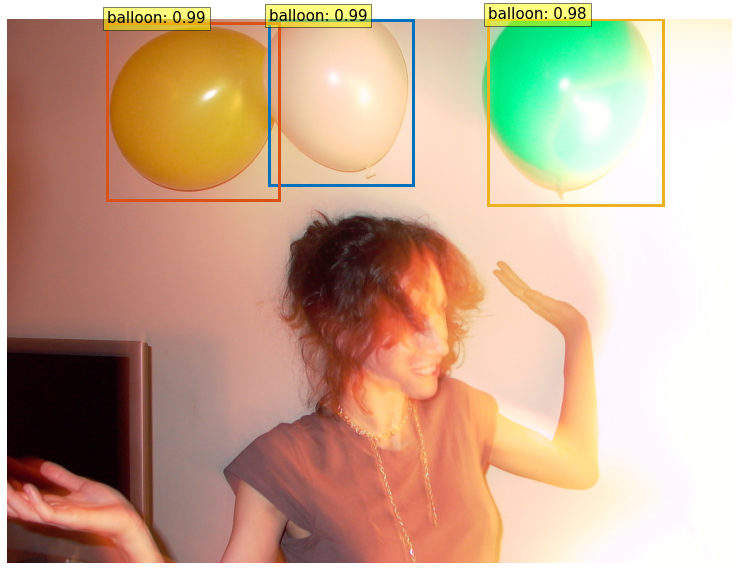

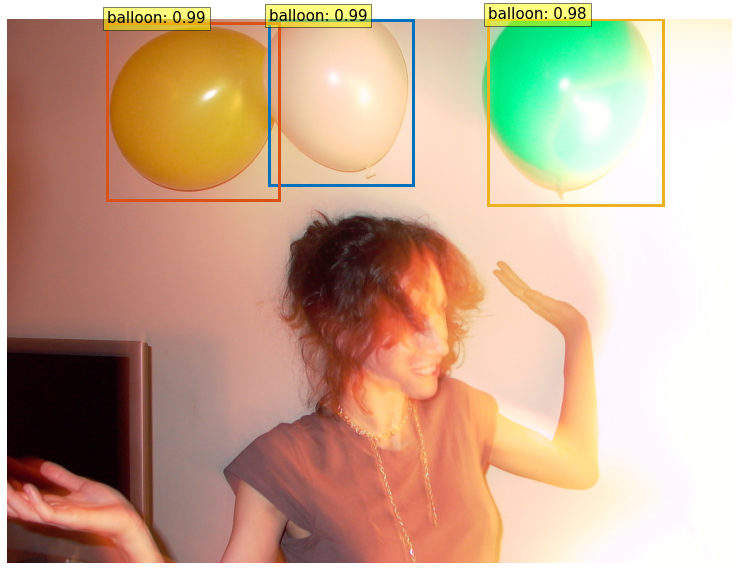

In [48]:
from PIL import Image

img_name = '/home/smajchrowska/detr/balloon/val2017/410488422_5f8991f26e_b.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)